In [3]:
import torch
from llms_from_scratch.ch04 import GPTModel

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [12]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
%

UsageError: Line magic function `%` not found.


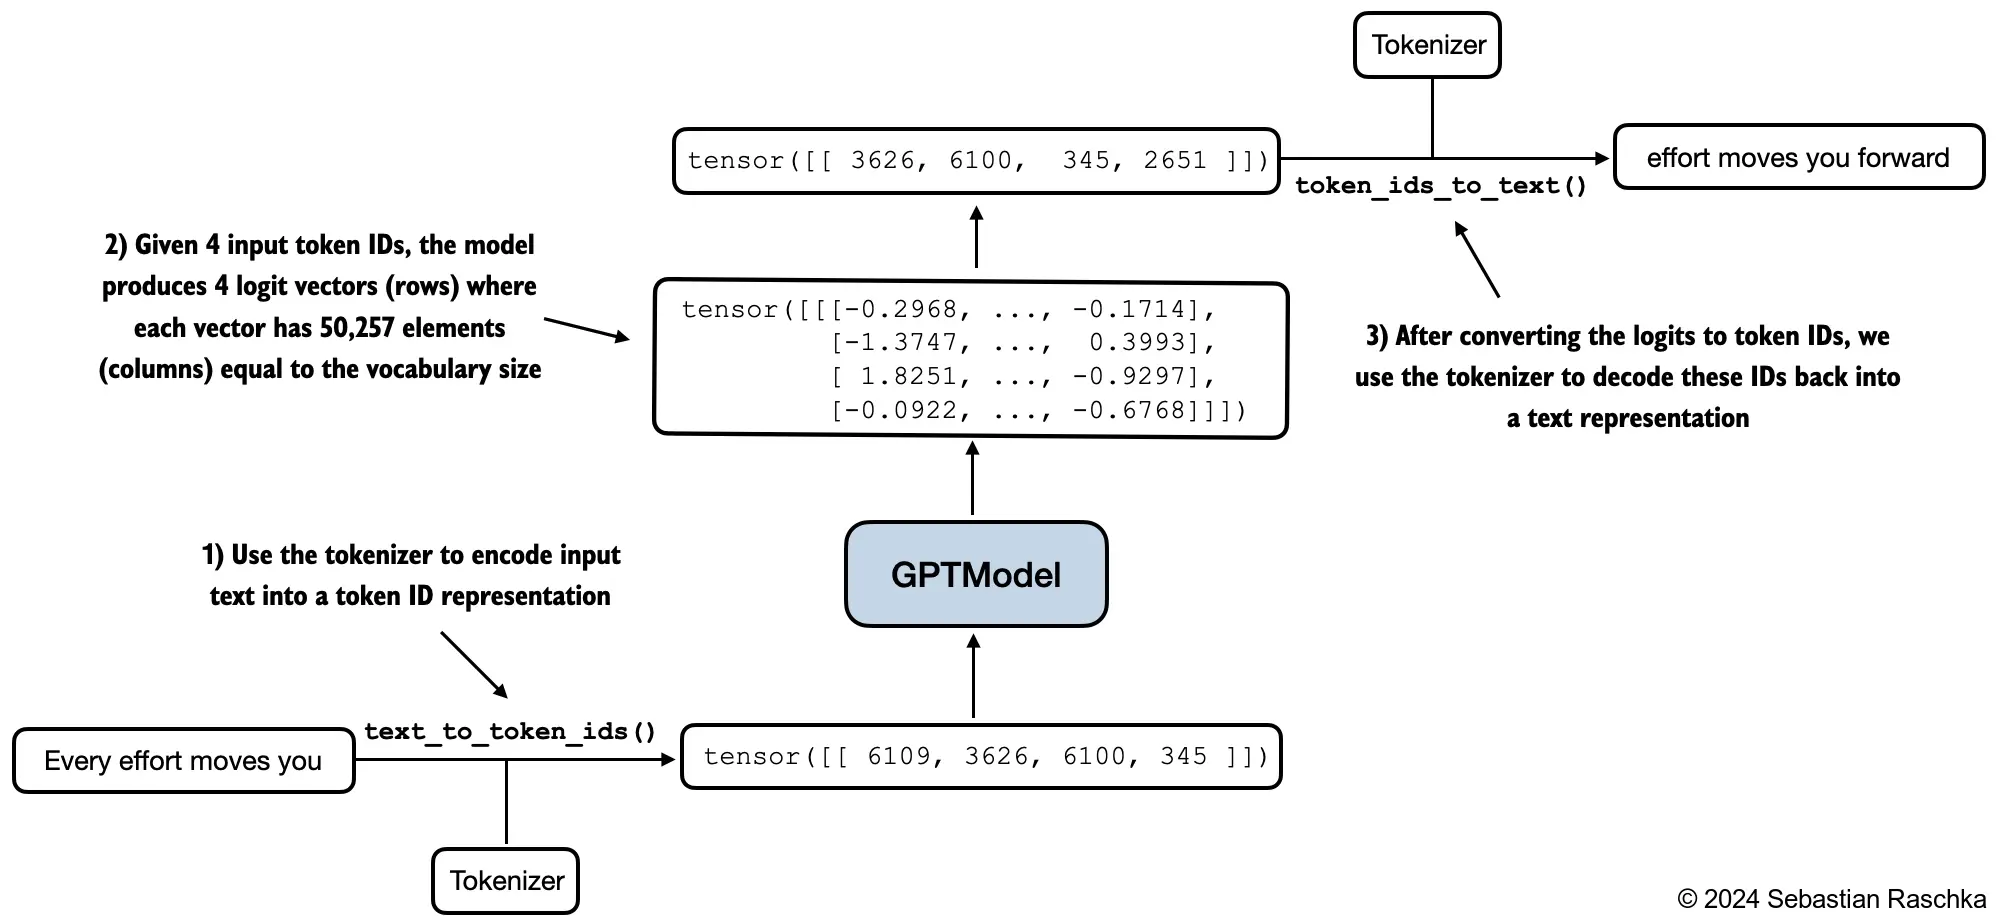

In [13]:
import tiktoken
from llms_from_scratch.ch04 import generate_text_simple

In [15]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor

def tokens_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)

    return tokenizer.decode(flat.tolist())

In [16]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer), max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])

In [17]:
tokens_ids_to_text(token_ids, tokenizer)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

### 1. Text generation loss

In [27]:
inputs = torch.tensor([
    [16833, 3626, 6100], # 'every effort moves'
    [40, 1107, 588]      # 'I really like'
])

targets = torch.tensor([
    [3626, 6100, 345],   # ' effort moves you'
    [1107, 588, 11311]   # ' really like chocolate'
])

In [29]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [34]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
token_ids

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

In [39]:
print("Target:", tokens_ids_to_text(targets[0], tokenizer))
print("Output:", tokens_ids_to_text(token_ids[0].flatten(), tokenizer))

Target:  effort moves you
Output:  Armed heNetflix


---

#### Cross entropy loss

- negative average log probability of the target and the model's output

In [43]:
target_probas_1 = probas[0, [0, 1, 2], targets[0]]
print("Text 1:", target_probas_1)

target_probas_2 = probas[1, [0, 1, 2], targets[1]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


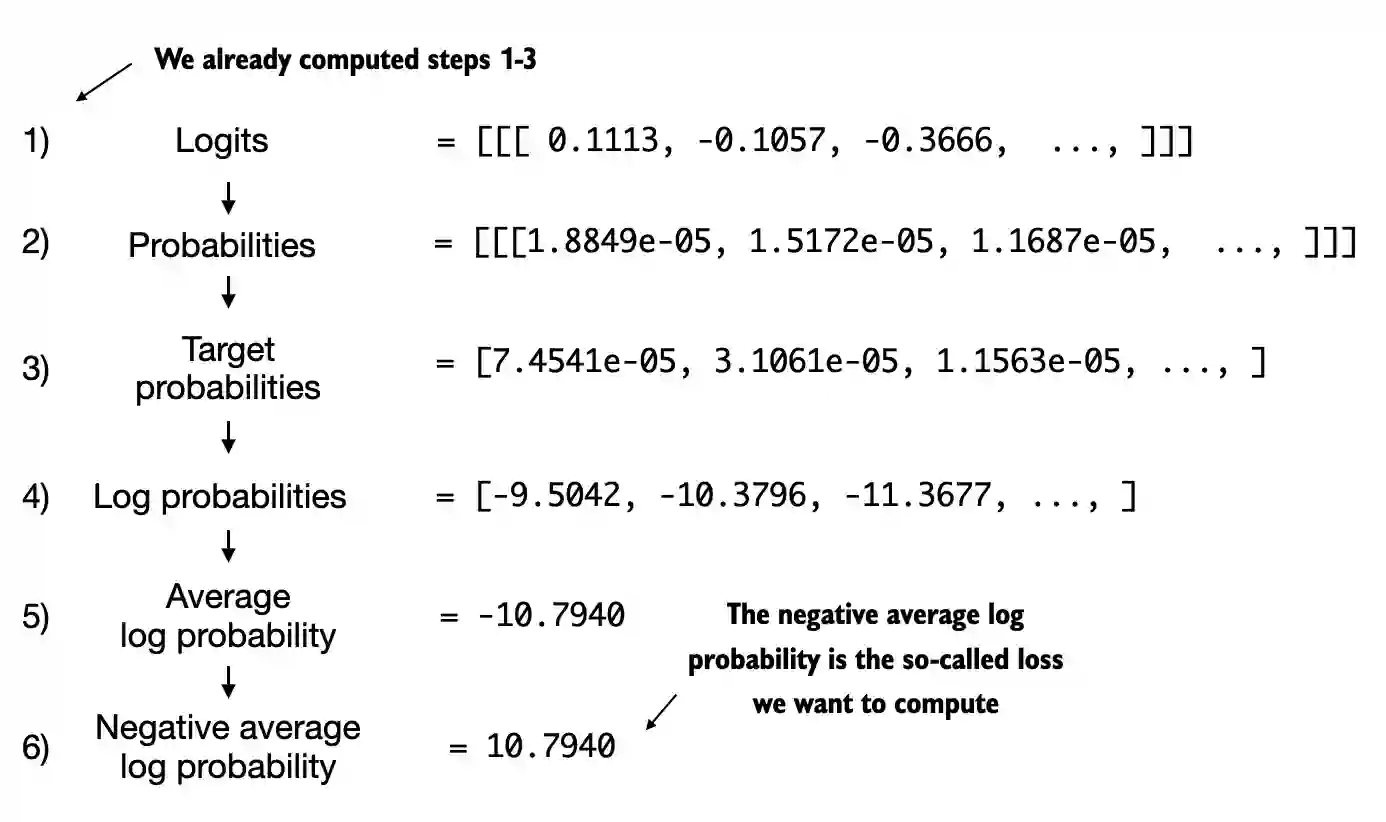

In [44]:
log_probas = torch.log(torch.cat([target_probas_1, target_probas_2]))
log_probas

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])

In [48]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
neg_avg_log_probas = -avg_log_probas
neg_avg_log_probas

tensor(-10.7940)


tensor(10.7940)

---

In [49]:
print(logits.shape)
print(targets.shape)

torch.Size([2, 3, 50257])
torch.Size([2, 3])


In [50]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print(logits_flat.shape)
print(targets_flat.shape)

torch.Size([6, 50257])
torch.Size([6])


In [51]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
loss

tensor(10.7940)

---

#### Training & validation losses

In [52]:
file_path = "the-verdict.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [55]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(("Characters:", total_characters))
print(("Tokens:", total_tokens))

('Characters:', 20479)
('Tokens:', 5145)


In [56]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

----

In [57]:
from llms_from_scratch.ch02 import create_dataloader_v1

In [59]:
torch.manual_seed(123)

In [61]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [70]:
for x, y in train_loader:
    print(x.shape, y.shape)

print("---"*14)
for x, y in val_loader:
    print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
------------------------------------------
torch.Size([2, 256]) torch.Size([2, 256])


---

In [71]:
def cacl_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss

In [72]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_loader(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss/num_batches

In [76]:
device = torch.device('mps') # using mac gpu
device

device(type='mps')

In [ ]:
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Train loss:", train_loss)
print('')